In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import h5py

mpl.rcParams['image.cmap'] = 'Spectral_r'
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['axes.grid'] = True

%matplotlib inline

In [2]:
def fit_sinusoid(freqs, amp):
    """
    Fit A0 + A1*sin(2π f0 * freq + φ) to one antenna's amplitude.
    Returns: (A0, A1, f0, phi)
    """

    # --- build frequency grid ---
    x = freqs

    # --- initial guess using FFT peak ---
    # FFT-based estimate for ripple frequency
    n = len(x)
    df = np.diff(x).mean()
    fftv = np.fft.rfft(amp - np.mean(amp))
    freq_fft = np.fft.rfftfreq(n, df)
    peak_idx = np.argmax(np.abs(fftv[1:])) + 1
    f0_guess = freq_fft[peak_idx]

    # sinusoid model linearised:
    # amp = A0 + B*sin(2π f0 x) + C*cos(2π f0 x)
    w = 2*np.pi*f0_guess*x
    M = np.column_stack([np.ones_like(x), np.sin(w), np.cos(w)])

    # least-squares
    sol, *_ = np.linalg.lstsq(M, amp, rcond=None)
    A0, B, C = sol

    # convert to amplitude/phase
    A1 = np.sqrt(B**2 + C**2)
    phi = np.arctan2(C, B)

    return A0, A1, f0_guess, phi

def load_h5parm_data(h5file, solset='sol000', soltab='amplitude000'):
    path = f"{solset}/{soltab}"

    with h5py.File(h5file, "r") as f:
        grp = f[path]

        freqs = grp["freq"][()]
        ants  = grp["ant"].asstr()[()]
        pols  = grp["pol"].asstr()[()]
        vals  = grp["val"][()]    # (time, freq, ant, pol)

    vals = np.nanmean(vals, axis=0)  # → (freq, ant, pol)

    return freqs, ants, pols, vals


def plot_amp_fft(freqs, ants, pols, vals, ant_sel='0-48', fit=False):
    """
    Plot amplitude + FFT(|G|). Optionally fit a sinusoid to the mean amplitude.
    """
    # --- antenna selection ---
    if '-' in ant_sel:
        start, end = map(int, ant_sel.split('-'))
        idx_sel = np.arange(start, min(end + 1, len(ants)))
    else:
        idx_sel = np.array([int(i) for i in ant_sel.split(',') if i.strip().isdigit()])
        idx_sel = idx_sel[idx_sel < len(ants)]

    # --- pol indices ---
    def get_pol_idx(polname):
        return list(pols).index(polname) if polname in pols else None
    pol_xx = get_pol_idx('XX')
    pol_yy = get_pol_idx('YY')

    # --- figure ---
    fig, axes = plt.subplots(2, 2, figsize=(12, 10),
                             sharey='row', sharex=False)
    plt.subplots_adjust(hspace=0.3, wspace=0.15)
    titles = ['Amplitude', 'FFT(|G|)']

    for j, pol_idx in enumerate([pol_xx, pol_yy]):
        pol_name = ['XX', 'YY'][j]
        if pol_idx is None:
            for ax in axes[:, j]:
                ax.text(0.5, 0.5, f'{pol_name} not found',
                        ha='center', va='center')
            continue

        data = vals[:, idx_sel, pol_idx]  # (n_freq, n_sel)
        amp = np.abs(data)

        # --- FFT -> delay domain ---
        df = np.diff(freqs).mean()
        nfreq = len(freqs)
        fftv = np.abs(np.fft.fftshift(np.fft.fft(amp, axis=0), axes=0))
        tau  = np.fft.fftshift(np.fft.fftfreq(nfreq, d=df))
        tau_us = tau * 1e6

        # all antennas in grey
        for i in range(amp.shape[1]):
            axes[0, j].plot(freqs, amp[:, i], color='0.7', lw=0.5)
            axes[1, j].plot(tau_us, fftv[:, i], color='0.7', lw=0.5)

        # average (red)
        mean_amp = np.nanmean(amp, axis=1)
        axes[0, j].plot(freqs, mean_amp, 'r', lw=1.2, label='mean')
        axes[1, j].plot(tau_us, np.nanmean(fftv, axis=1), 'r', lw=1.2)

        # --- sinusoid fit on the mean amplitude ---
        if fit:
            A0, A1, f0, phi = fit_sinusoid(freqs, mean_amp)
            model = A0 + A1 * np.sin(2*np.pi*f0*freqs + phi)
            tau_us = f0 * 1e6     # convert seconds → microseconds
            axes[0, j].plot(freqs, model, 'g', lw=1.4, label='sin fit')
            axes[1, j].axvline(- tau_us, color='g', lw=1.3, ls='--',
                               label=f"τ_fit = {tau_us:.2f} µs")
            axes[1, j].axvline(tau_us, color='g', lw=1.3, ls='--',
                               label=f"τ_fit = {tau_us:.2f} µs")

            print(f"\n[{pol_name}] sinusoid fit parameters:")
            print(f"A0   = {A0:.5g}")
            print(f"A1   = {A1:.5g}")
            print(f"τ = {tau_us:.3f} µs")
            print(f"phi  = {phi:.5g} rad")

        axes[0, j].set_title(pol_name)
        axes[0, j].set_xlabel('Frequency [Hz]')
        axes[1, j].set_xlabel('Delay [µs]')
        axes[1, j].set_yscale('log')
        axes[1, j].axvline(0, color='k', lw=0.8, ls=':')

    for i, label in enumerate(titles):
        axes[i, 0].set_ylabel(label)

    if fit:
        axes[0, 0].legend()

    plt.suptitle(f"Antenna selection: {ant_sel} ({len(idx_sel)} antennas)", y=0.96)
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_2645038/3463124434.py:45: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=0)  # → (freq, ant, pol)



[XX] sinusoid fit parameters:
A0   = 0.97296
A1   = 0.0038976
τ = 0.918 µs
phi  = -1.5426 rad

[YY] sinusoid fit parameters:
A0   = 0.97295
A1   = 0.0038134
τ = 0.918 µs
phi  = -1.6016 rad


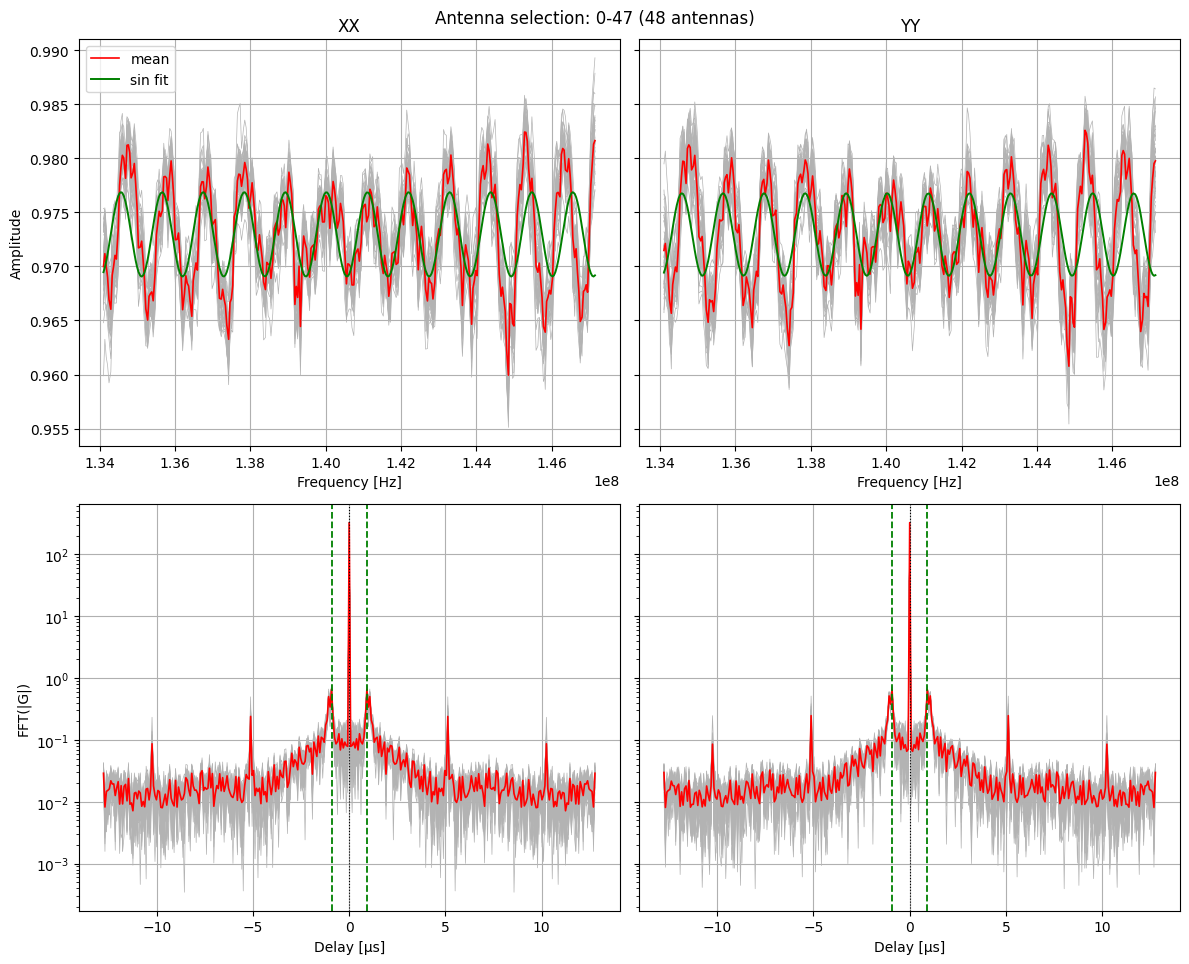

In [3]:
h5file = '/net/node310/data/users/lofareor/mertens/srcnet/dsc-037/L253456-bpcal_run_23/bandpass-gaincal.h5'
freqs, ants, pols, vals = load_h5parm_data(h5file)
plot_amp_fft(freqs, ants, pols, vals, ant_sel='0-47', fit=True)